In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import xgboost as xgb
import pickle

%matplotlib inline
warnings.filterwarnings("ignore")

from numpy.random import seed
seed(1)

In [2]:
df = pd.read_csv('data/train.csv')

# Data Preprocessing

In [3]:
df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [4]:
df.isna().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [5]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [6]:
df = df.set_index('Order Date')

In [7]:
df.head()

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,,,
08/11/2017,1,CA-2017-152156,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
08/11/2017,2,CA-2017-152156,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
12/06/2017,3,CA-2017-138688,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
11/10/2016,4,US-2016-108966,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
11/10/2016,5,US-2016-108966,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [8]:
df['Country'].unique()

array(['United States'], dtype=object)

In [9]:
df['State'].unique()

array(['Kentucky', 'California', 'Florida', 'North Carolina',
       'Washington', 'Texas', 'Wisconsin', 'Utah', 'Nebraska',
       'Pennsylvania', 'Illinois', 'Minnesota', 'Michigan', 'Delaware',
       'Indiana', 'New York', 'Arizona', 'Virginia', 'Tennessee',
       'Alabama', 'South Carolina', 'Oregon', 'Colorado', 'Iowa', 'Ohio',
       'Missouri', 'Oklahoma', 'New Mexico', 'Louisiana', 'Connecticut',
       'New Jersey', 'Massachusetts', 'Georgia', 'Nevada', 'Rhode Island',
       'Mississippi', 'Arkansas', 'Montana', 'New Hampshire', 'Maryland',
       'District of Columbia', 'Kansas', 'Vermont', 'Maine',
       'South Dakota', 'Idaho', 'North Dakota', 'Wyoming',
       'West Virginia'], dtype=object)

In [10]:
df[df['State'] == 'Hawaii']

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,,,


In [11]:
df.head()

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,,,
08/11/2017,1,CA-2017-152156,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
08/11/2017,2,CA-2017-152156,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
12/06/2017,3,CA-2017-138688,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
11/10/2016,4,US-2016-108966,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
11/10/2016,5,US-2016-108966,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [12]:
len(df['Customer ID'].unique())

793

In [13]:
df['Segment'].unique()

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

In [14]:
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [15]:
df['Sub-Category'].unique()

array(['Bookcases', 'Chairs', 'Labels', 'Tables', 'Storage',
       'Furnishings', 'Art', 'Phones', 'Binders', 'Appliances', 'Paper',
       'Accessories', 'Envelopes', 'Fasteners', 'Supplies', 'Machines',
       'Copiers'], dtype=object)

In [16]:
len(df['Product ID'].unique())

1861

Now we can drop these features:
    - Row ID(unused ID)
    - Order ID(it's created after order is places)
    - Ship Date(it's created after order is places)
    - Ship Mode(it's created after order is places)
    - Customer Name(we have Customer ID)
    - Country(it has only United States as value)
    - Region(there are attributes State, City and Postal Code)
    - Product Name(we have Product ID)

In [17]:
# drop features
df = df.drop(['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer Name', 'Country', 'Region', 'Product Name'], axis=1)

# Feature Engineering

In [18]:
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

In [19]:
df = df.sort_index(ascending=True)

In [20]:
print(f'First order date: {np.min(df.index)}')
print(f'Last order date: {np.max(df.index)}')

First order date: 2015-01-03 00:00:00
Last order date: 2018-12-30 00:00:00


In [21]:
df.head()

,Customer ID,Segment,City,State,Postal Code,Product ID,Category,Sub-Category,Sales
Order Date,,,,,,,,,
2015-01-03,DP-13000,Consumer,Houston,Texas,77095.0,OFF-PA-10000174,Office Supplies,Paper,16.448
2015-01-04,PO-19195,Home Office,Naperville,Illinois,60540.0,OFF-BI-10004094,Office Supplies,Binders,3.540
2015-01-04,PO-19195,Home Office,Naperville,Illinois,60540.0,OFF-ST-10002743,Office Supplies,Storage,272.736
2015-01-04,PO-19195,Home Office,Naperville,Illinois,60540.0,OFF-LA-10003223,Office Supplies,Labels,11.784
2015-01-05,MB-18085,Consumer,Philadelphia,Pennsylvania,19143.0,OFF-AR-10003478,Office Supplies,Art,19.536


Let's see daily sales. We will also plot mean for last 30 days to see if there is any pattern in sales

In [22]:
# group by date
daily_sales = pd.DataFrame(df.groupby(df.index, as_index=True)['Sales'].sum())

In [23]:
daily_sales.head()

,Sales
Order Date,
2015-01-03,16.448
2015-01-04,288.060
2015-01-05,19.536
2015-01-06,4407.100
2015-01-07,87.158


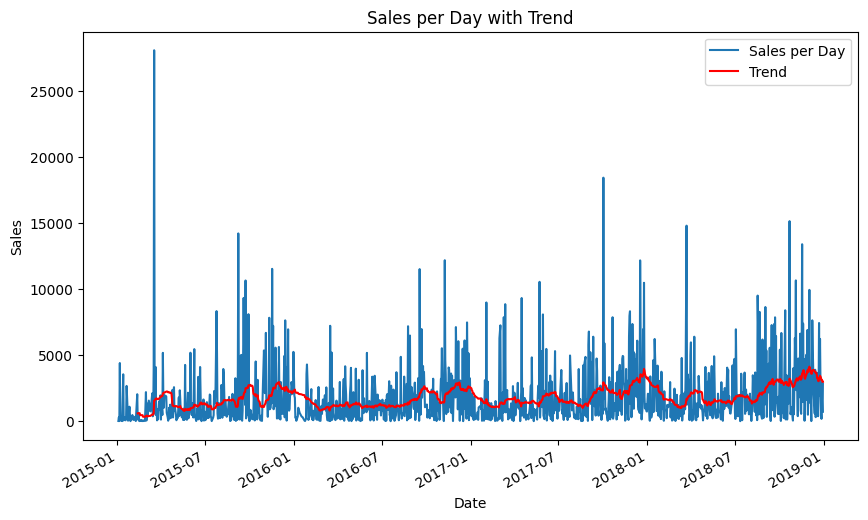

In [24]:
# plot daily sales
daily_sales['Sales'].plot(style='-', figsize=(10, 6), label='Sales per Day')

# plot mean for 30 days
rolling_mean = daily_sales['Sales'].rolling(window=30).mean()
rolling_mean.plot(color='red', label='Trend')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales per Day with Trend')

plt.legend()

plt.show()

We can observe, that in the end of each year there are always 2 hunches in the sales. So, for long-term predictions, it would make sense to add lag features to the dataframe

In [25]:
df.head()

,Customer ID,Segment,City,State,Postal Code,Product ID,Category,Sub-Category,Sales
Order Date,,,,,,,,,
2015-01-03,DP-13000,Consumer,Houston,Texas,77095.0,OFF-PA-10000174,Office Supplies,Paper,16.448
2015-01-04,PO-19195,Home Office,Naperville,Illinois,60540.0,OFF-BI-10004094,Office Supplies,Binders,3.540
2015-01-04,PO-19195,Home Office,Naperville,Illinois,60540.0,OFF-ST-10002743,Office Supplies,Storage,272.736
2015-01-04,PO-19195,Home Office,Naperville,Illinois,60540.0,OFF-LA-10003223,Office Supplies,Labels,11.784
2015-01-05,MB-18085,Consumer,Philadelphia,Pennsylvania,19143.0,OFF-AR-10003478,Office Supplies,Art,19.536


In [26]:
df_lt = df.copy()

In [27]:
df_lt.head()

,Customer ID,Segment,City,State,Postal Code,Product ID,Category,Sub-Category,Sales
Order Date,,,,,,,,,
2015-01-03,DP-13000,Consumer,Houston,Texas,77095.0,OFF-PA-10000174,Office Supplies,Paper,16.448
2015-01-04,PO-19195,Home Office,Naperville,Illinois,60540.0,OFF-BI-10004094,Office Supplies,Binders,3.540
2015-01-04,PO-19195,Home Office,Naperville,Illinois,60540.0,OFF-ST-10002743,Office Supplies,Storage,272.736
2015-01-04,PO-19195,Home Office,Naperville,Illinois,60540.0,OFF-LA-10003223,Office Supplies,Labels,11.784
2015-01-05,MB-18085,Consumer,Philadelphia,Pennsylvania,19143.0,OFF-AR-10003478,Office Supplies,Art,19.536


Since we need to calculate daily sales, we need to aggregate our data on dates. We cannot aggregate the following features, so we need to drop them.

In [28]:
# drop features
df_lt = df_lt.drop(['Customer ID', 'Segment', 'City', 'State', 'Postal Code', 'Product ID', 'Category', 'Sub-Category'], axis=1)

In [29]:
df_lt.head()

,Sales
Order Date,
2015-01-03,16.448
2015-01-04,3.540
2015-01-04,272.736
2015-01-04,11.784
2015-01-05,19.536


Now we can see that the only feature that is left is Sales. We will add some more features later on.

In [30]:
# group by date
df_lt = pd.DataFrame(df_lt.groupby(df_lt.index)['Sales'].sum())

In [31]:
df_lt.head()

,Sales
Order Date,
2015-01-03,16.448
2015-01-04,288.060
2015-01-05,19.536
2015-01-06,4407.100
2015-01-07,87.158


In [32]:
df_lt = df_lt.sort_index(ascending=True)

In [33]:
df_lt.head()

,Sales
Order Date,
2015-01-03,16.448
2015-01-04,288.060
2015-01-05,19.536
2015-01-06,4407.100
2015-01-07,87.158


## Adding Lag Features

In this step we will add Lag features. These are the features that represent the value some days ago or in the future for another date. In our case we will use them to represent previous hunches for the next ones.

In [34]:
# add lags
df_lt['Lag_364'] = df_lt['Sales'].shift(364)
df_lt['Lag_728'] = df_lt['Sales'].shift(728)
df_lt['Lag_1096'] = df_lt['Sales'].shift(1096)

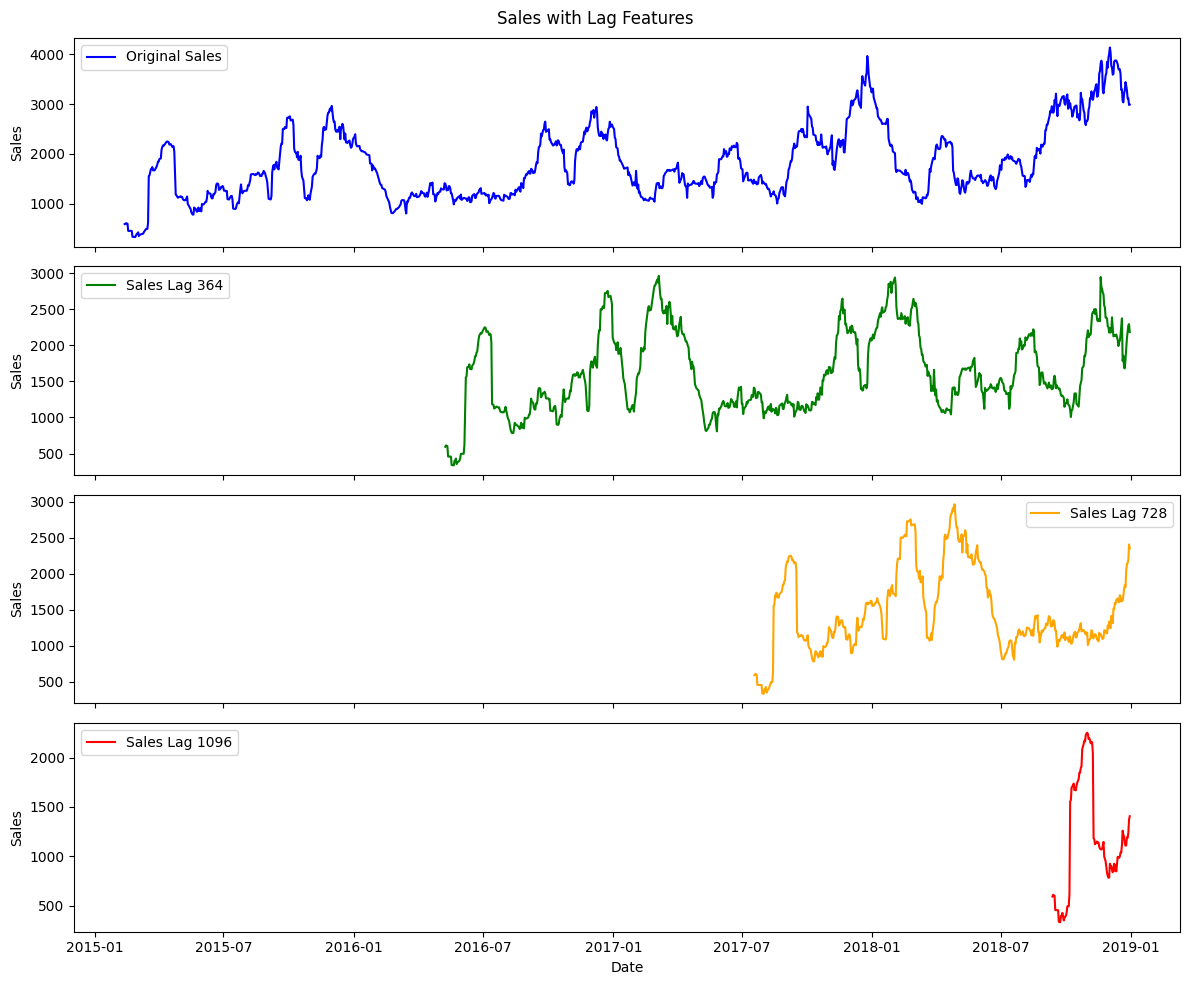

In [35]:
# plot lags
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(df_lt.index, df_lt['Sales'].rolling(window=30).mean(), label='Original Sales', color='blue')
axes[0].set_ylabel('Sales')
axes[0].legend()

axes[1].plot(df_lt.index, df_lt['Lag_364'].rolling(window=30).mean(), label='Sales Lag 364', linestyle='-', color='green')
axes[1].set_ylabel('Sales')
axes[1].legend()

axes[2].plot(df_lt.index, df_lt['Lag_728'].rolling(window=30).mean(), label='Sales Lag 728', linestyle='-', color='orange')
axes[2].set_ylabel('Sales')
axes[2].legend()

axes[3].plot(df_lt.index, df_lt['Lag_1096'].rolling(window=30).mean(), label='Sales Lag 1096', linestyle='-', color='red')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Sales')
axes[3].legend()

plt.suptitle('Sales with Lag Features')
plt.tight_layout()
plt.show()

We can see that pattern appears not year after year exactly. There is a minor shift. However, we don't need to align Lags, since it can cause overfitting. And leaving them like we have now will help the algorithm to understand that pattern is a bit shifted.

## Adding Time Features

We will also add time features. It's just the features that represent the date in distinct columns.

In [36]:
def create_time_features(df_to_change):
    """
    This function adds Time Features to the dataframe that is passed
    :param df_to_change: dataframe to add the features to
    :return: copy of passed dataframe with Time Features
    """
    df_copy = df_to_change.copy()
    df_copy['year'] = df_copy.index.year
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['dayofweek'] = df_copy.index.dayofweek
    df_copy['dayofyear'] = df_copy.index.dayofyear
    return df_copy

In [37]:
df_lt = create_time_features(df_lt)

In [38]:
df_lt.head()

,Sales,Lag_364,Lag_728,Lag_1096,year,month,day,dayofweek,dayofyear
Order Date,,,,,,,,,
2015-01-03,16.448,NaN,NaN,NaN,2015,1,3,5,3
2015-01-04,288.060,NaN,NaN,NaN,2015,1,4,6,4
2015-01-05,19.536,NaN,NaN,NaN,2015,1,5,0,5
2015-01-06,4407.100,NaN,NaN,NaN,2015,1,6,1,6
2015-01-07,87.158,NaN,NaN,NaN,2015,1,7,2,7


# Model Training

Now we are ready to train the model. First, we will try to do it with TimeSeriesSplit, which is an alternative to Cross Validation, but for Time Series Data.

In [39]:
# create split
tss = TimeSeriesSplit(n_splits=5, test_size=180)
df_lt = df_lt.sort_index()

best_model = None
best_score = np.inf

for fold, (train_idx, val_idx) in enumerate(tss.split(df_lt)):
    # split the data
    train = df_lt.iloc[train_idx]
    test = df_lt.iloc[val_idx]

    FEATURES = ['dayofyear', 'dayofweek', 'month','year',
                'Lag_364', 'Lag_728', 'Lag_1096']
    TARGET = 'Sales'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    # initialize and fit the model
    reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    # make predictions
    y_pred = reg.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))

    # update the model if needed
    if score < best_score:
        best_score = score
        best_model = reg


[0]	validation_0-rmse:2871.77915	validation_1-rmse:2159.07314
[100]	validation_0-rmse:2224.31170	validation_1-rmse:1663.82599
[200]	validation_0-rmse:1950.72906	validation_1-rmse:1577.71140
[275]	validation_0-rmse:1879.37699	validation_1-rmse:1577.05614
[0]	validation_0-rmse:2641.72082	validation_1-rmse:2656.13606
[100]	validation_0-rmse:2046.06361	validation_1-rmse:2114.34083
[200]	validation_0-rmse:1892.18714	validation_1-rmse:2077.17087
[234]	validation_0-rmse:1861.13624	validation_1-rmse:2143.33677
[0]	validation_0-rmse:2646.09932	validation_1-rmse:2891.44026
[100]	validation_0-rmse:2093.49041	validation_1-rmse:2361.61223
[200]	validation_0-rmse:1958.08423	validation_1-rmse:2296.66631
[274]	validation_0-rmse:1917.52396	validation_1-rmse:2293.49699
[0]	validation_0-rmse:2698.33125	validation_1-rmse:2979.56764
[100]	validation_0-rmse:2120.44196	validation_1-rmse:2400.09463
[200]	validation_0-rmse:1985.90454	validation_1-rmse:2264.13656
[300]	validation_0-rmse:1906.16100	validation_1-

In [40]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

Now we got our best model. Let's create a function for evaluation and plot the results

In [41]:
def plot_predictions(n, features, label, dataframe, model, window_size):
    """
    This function makes prediction on given data and draw them. If train/val/test set is passed, compare its data with predicted and calculated RMSE and MAE
    :param n: number of rows to make prediction on
    :param features: list of features
    :param label: name of the label
    :param dataframe: dataframe to make predictions on
    :param model: model to use for predictions
    :param window_size: window size for rolling mean
    :return: RMSE and MAE
    """
    if dataframe[label].isna().all():
        plot_df = dataframe.iloc[-n:, df_lt.columns.isin(features)]
        predictions = model.predict(plot_df[features])
        plot_df['Predicted'] = predictions

        plt.figure(figsize=(10, 6))

        plt.plot(plot_df.index, plot_df['Predicted'], label='Predictions', color='red')

        plt.xlabel('Dates')
        plt.ylabel('Values')
        plt.title('Real Data, Predictions, Mean')

        plt.legend()

        plt.grid(True)
        plt.show()
    else:
        test_data = dataframe.iloc[-n:, df_lt.columns.isin(features)]
        predictions = model.predict(test_data[features])
        plot_df = dataframe.iloc[-n:, dataframe.columns.isin([label])]
        plot_df['Predicted'] = predictions
        mean = plot_df[label].rolling(window=window_size).mean()

        plt.figure(figsize=(10, 6))

        plt.plot(plot_df.index, plot_df[label], label='Real Data', color='blue')
        plt.plot(plot_df.index, plot_df['Predicted'], label='Predictions', color='red')
        mean.plot(color='green', label='Trend')

        plt.xlabel('Dates')
        plt.ylabel('Values')
        plt.title('Real Data, Predictions, Mean')

        plt.legend()

        plt.grid(True)
        plt.show()

        rmse = np.sqrt(mean_squared_error(y_pred=plot_df['Predicted'], y_true=plot_df['Sales']))
        mae = mean_absolute_error(y_pred=plot_df['Predicted'], y_true=plot_df['Sales'])

        return rmse, mae

In [42]:
FEATURES = ['dayofyear', 'dayofweek', 'month','year',
                'Lag_364','Lag_728','Lag_1096']

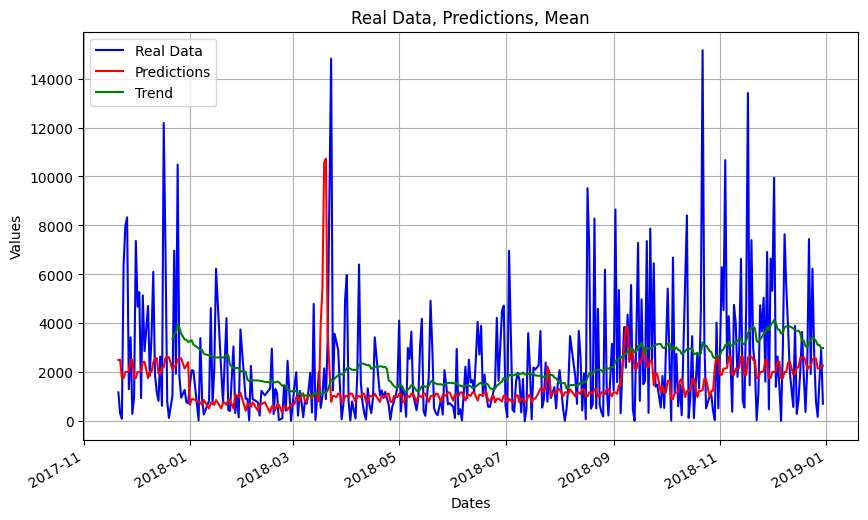

(2683.809514403985, 1713.8496730547417)

In [43]:
plot_predictions(360, FEATURES, 'Sales', df_lt, best_model, 30)

We can see that this model has high generalization on the data. While it can be a good model for some tasks, it would be wise to create a new one, that fits the data better. For that we will use RandomizedSearch. It wouldn't take long, because our dataset isn't very big.

Note, that this regressor catches the pattern of 2 hunches.

In [44]:
# split the data
X = df_lt[FEATURES].values
y = df_lt['Sales'].values

# define param grid
param_grid = {
    'max_depth': range(3, 10),  # Maximum depth of the trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees (boosting rounds)
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization term on weights
    'reg_lambda': [0, 0.1, 0.5, 1.0],  # L2 regularization term on weights
}

# initialize and train the model
regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

random_search = RandomizedSearchCV(estimator=regressor, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': range(3, 10),
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0, 0.1, 0.5, 1.0],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [45]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", np.sqrt(-random_search.best_score_))

Best Parameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best Score: 2193.8287297471493


We got our best estimator. Let's see its predictions.

In [46]:
rs_best_model = random_search.best_estimator_

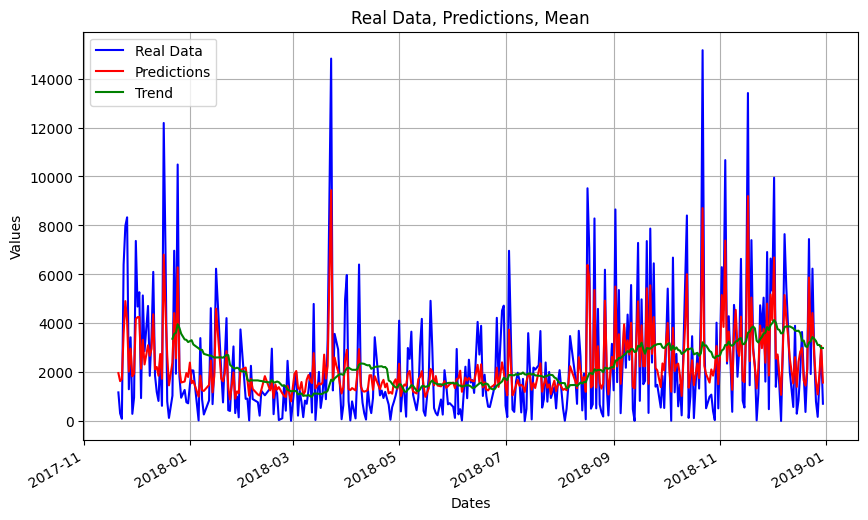

(1346.7485407541305, 1033.0792639754231)

In [47]:
plot_predictions(360, FEATURES, 'Sales', df_lt, rs_best_model, 30)

As expected, this estimator fits the data much better. However, it might overfit. This has to be tested in production. Let's compare two models on future dataframes.

In [48]:
def create_future_dataframe(start_time, end_time, features, initial_df):
    """
    This function creates dataframe with labels for the future for a specified time range
    :param start_time: start of timerange
    :param end_time: end of timerange
    :param features: list of features
    :param initial_df: dataframe to take Lag Features from
    :return: new dataframe with features for the future
    """
    date_range = pd.date_range(start=start_time, end=end_time, freq='D')
    empty_df = pd.DataFrame(index=date_range)

    for feature in features:
        empty_df[feature] = np.nan

    time_features_df = create_time_features(empty_df)

    concat_df = pd.concat([initial_df, time_features_df])

    concat_df['Lag_364'] = concat_df['Sales'].shift(364)
    concat_df['Lag_728'] = concat_df['Sales'].shift(728)
    concat_df['Lag_1096'] = concat_df['Sales'].shift(1096)

    time_features_df = concat_df[concat_df.index >= start_time]

    return time_features_df

In [49]:
future_dataframe = create_future_dataframe('2019-01-01', '2019-12-30', FEATURES, df_lt)

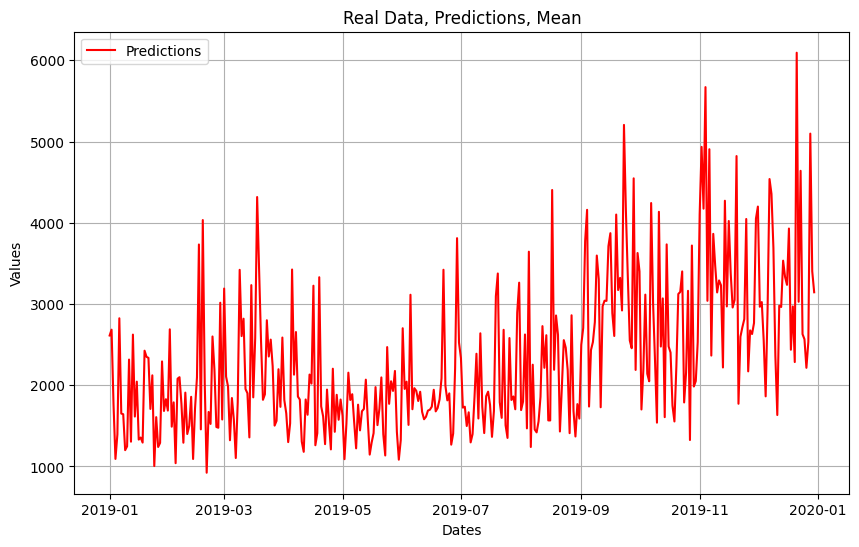

In [50]:
plot_predictions(364, FEATURES, 'Sales', future_dataframe, rs_best_model, 30)

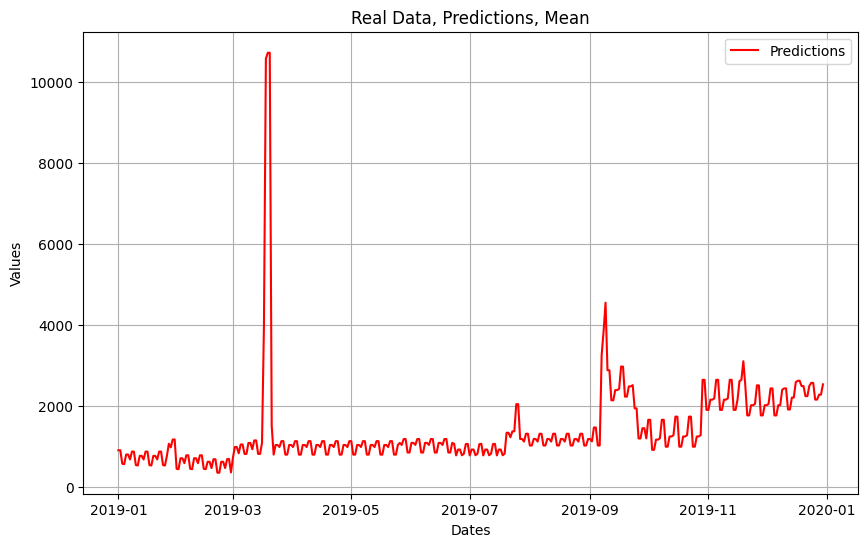

In [51]:
plot_predictions(364, FEATURES, 'Sales', future_dataframe, best_model, 30)

And again, we see what was expected. First model makes very detailed predictions, but it might overfit. Second model has very high generalization, but it can still be useful. It's a good practice to save them both.

In [52]:
with open('best_estimator.pkl', 'wb') as file:
    pickle.dump(rs_best_model, file)

with open('average_estimator.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Conclusion

First model looks very promising. There is more to do with feature engineering, but for we already got a decent solution. Even a classic ML estimator works good for that type of data. However, there is more that can be used:
    - Other classic algorithms
    - Recurrent Neural Networks
    - ARIMA
    - Prophet
    - Neural Prophet
Each of the algorithms can be a good choice in one or another situation.